In [1]:
import numpy as np
import scipy.linalg as la
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cvxpy as cvx
import sklearn.linear_model as lm

In [2]:
import itertools as it

## Cosine transform

In [3]:
def cfunc(x_vec,k_vec,N): #define ω=πk/2N
    """ The function that generates elements of the multidimensional Fourier transform matrix
    
    Args:
        x_vec (list): The position coordinate vector.
        k_vec (list): The momentum coordinate vector.
        N      (int): The number of discrete points in each dimension (assuming they are all equal)

    Returns:
        float: The element cos(π*k[i]*(2*x[i]+1)/(2*N))*...*cos(π*k[d]*(2*x[d]+1)/(2*N)) with a normalization factor"""
    
    d = len(x_vec)
    temp_val = 2**d*np.prod([np.cos(np.pi*k_vec[i]*(2*x_vec[i]+1)/(2*N)) for i in range(d)])
    for i in k_vec:
        if i==0:
            temp_val*=1/np.sqrt(4*N)
        else:
            temp_val*=1/np.sqrt(2*N)
    return temp_val

In [298]:
def generate_Φ(nf,ndim):
    """ The function that generates the full measurement matrix, i.e. the multidimensional Fourier matrix.
    
    Args:
        nf   (int): The number of discrete points in each dimension (assuming they are all equal)
        ndim (int): The number of dimensions.

    Returns:
        array: The matrix Φ with elements c(x,v,N)"""
    
    Φ_temp = np.array([[cfunc(x,k,nf) for k in it.product(range(nf),repeat=ndim)] for x in it.product(range(nf),repeat=ndim)])
    return Φ_temp

In [300]:
def generate_ms(indxs,nf,ndim):
    """ The function that generates the full measurement matrix, i.e. the multidimensional Fourier matrix.
    
    Args:
        indxs (list): A list that contains indices of measured vectors where each index is a list of coordinates
        nf     (int): The number of discrete points in each dimension (assuming they are all equal)
        ndim   (int): The  number of dimensions.

    Returns:
        array: The matrix Φ_R with elements c(x,v,N) restricted only to the measured subspace"""
    
    Φ_temp = np.array([[cfunc(x,k,nf) for k in it.product(range(nf),repeat=ndim)] for x in indxs])
    return Φ_temp

In [209]:
def find_rep(nums,base,ndim):
    """ The function that converts an integer index to a list of coordinates.
    
    Args:
        nums  (list): A list of indices that are measured, where each element n is 0<=n<base**ndim
        base   (int): The number of discrete points in each dimension (assuming they are all equal)
        ndim   (int): The  number of dimensions.

    Returns:
        array: The converted indices of measured vectors where each index is now a list of coordinates"""    
    
    rep = []
    for i in range(ndim-1):
        rep.append(nums//(base**(ndim-i-1)))
        nums = nums%(base**(ndim-i-1))
    rep.append(nums)
    return np.array(rep).T

In [208]:
def reconstruct_sparse_cosine(m_vecs,y_vals,verbose=False):
    """ The function that reconstruct a sparse signal from incomplete measurements using cvx.
    
    Args:
        m_vecs  (array): The matrix Φ_R with elements c(x,v,N) restricted only to the measured subspace
        y_vals   (list): The list of measurement results
        verbose  (bool): Optional argument that shows the progress of the optimizer if True

    Returns:
        list: The reconstructed signal vector"""  
    
    vx = cvx.Variable(n_f*n_f)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [m_vecs*vx == y_vals]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=verb)
    
    return np.squeeze(np.array(vx.value))

In [304]:
def iterative_ht(m_vecs,y_vals,sparsity,threshold = 1e-3, max_iter=200,verbose=True):
    """ The function that reconstruct a sparse signal from incomplete measurements using cvx.
    
    Args:
        m_vecs     (array): The matrix Φ_R with elements c(x,v,N) restricted only to the measured subspace
        y_vals      (list): The list of measurement results
        sparsity     (int): The number of non-zero elements in the signal
        threshold  (float): The difference threshold between the solution and observations before the optimizer terminates
        max_iter   (float): The maximum number of iterations before the optimizer terminates 
        verbose     (bool): Optional argument that shows the progress of the optimizer if True

    Returns:
        list: The reconstructed signal vector"""  
    
    x_vec = np.zeros(m_vecs.shape[1])
    ic = 0
    while np.linalg.norm(y_vals-m_vecs@x_vec)>threshold and ic<max_iter:
        ic += 1
        x_vec = x_vec + m_vecs.T@(y_vals-m_vecs@x_vec)
        x_vec[np.argsort(-np.abs(x_vec))[sparsity:]] = 0
        
        if verbose:
            workdone = (ic)/max_iter
            print("\rProgress: [{0:50s}] {1:.1f}%".format('#' * int(workdone * 50), workdone*100), end="", flush=True)
    return x_vec 

## Test

### Signal

In [299]:
n_f = 25
n_dim = 2
Φ_mat = generate_Φ(n_f,n_dim)

In [301]:
test_rvec = np.array([np.cos(x)*np.cos(y)+np.cos(2*x)*np.cos(2*y) for x in range(n_f) for y in range(n_f)])

In [302]:
test_fvec = Φ_mat@test_rvec

Test signal in the real space

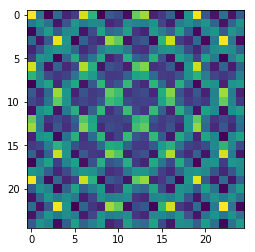

In [274]:
plt.imshow(test_rvec.reshape((n_f,n_f)))

Test signal in the Fourier space

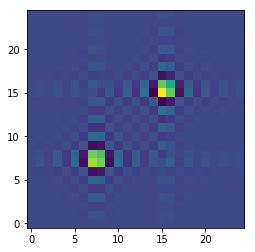

In [311]:
plt.imshow(test_fvec.reshape((n_f,n_f)),origin='lower')

### CVX

In [308]:
m = 200
rand_indx = np.random.choice(range(625),m,replace=False)

In [309]:
rand_indx_v = find_rep(rand_indx,n_f,n_dim)
m_vec_list  = generate_ms(rand_indx_v,n_f,n_dim)

In [310]:
test_rec = reconstruct_sparse_cosine(Φ_mat[rand_indx],np.array(test_rvec)[rand_indx])

In [293]:
# cost_record_iht = []
cost_record_cvx_time = []
for m in range(10,200):
    rand_indx = np.random.choice(np.arange(n_f*n_f),m,replace=False)
    x_sol = reconstruct_sparse_cosine(Φ_mat[rand_indx],np.array(test_rvec)[rand_indx])
#     cost_record_iht.append(np.linalg.norm(rec_ct-x_sol))
    cost_record_cvx_time.append(np.linalg.norm(Φ_mat@x_sol-np.array(test_rvec)))

Text(0,0.5,'cost')

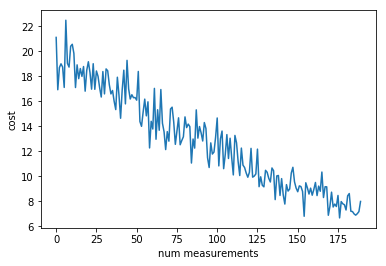

In [306]:
plt.plot(cost_record_cvx_time)
plt.xlabel('num measurements')
plt.ylabel('cost')

Sample recovered signal in the Fourier domain

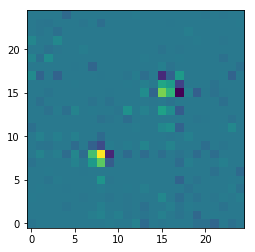

In [296]:
plt.imshow(x_sol.reshape((n_f,n_f)),origin='lower')

## IHT

In [271]:
test_iht = iterative_ht(Φ_mat[rand_indx],np.array(test_rvec)[rand_indx],sparsity = 20,verbose=True)

Progress: [##################################################] 100.0%

Sample recovered signal in the Fourier domain

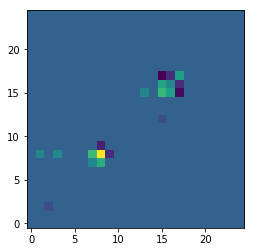

In [272]:
plt.imshow(test_iht.reshape((n_f,n_f)),origin='lower')

In [290]:
# cost_record_iht = []
cost_record_iht_time = []
for m in range(10,200):
    rand_indx = np.random.choice(np.arange(n_f*n_f),m,replace=False)
    x_sol = iterative_ht(Φ_mat[rand_indx],np.array(test_rvec)[rand_indx],sparsity = 20,verbose=False)
#     cost_record_iht.append(np.linalg.norm(rec_ct-x_sol))
    cost_record_iht_time.append(np.linalg.norm(Φ_mat@x_sol-np.array(test_rvec)))

Text(0,0.5,'cost')

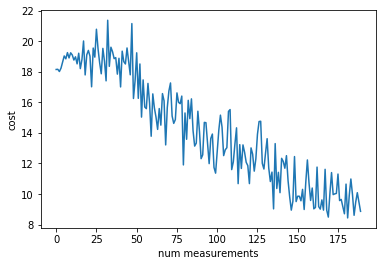

In [307]:
plt.plot(cost_record_iht_time)
plt.xlabel('num measurements')
plt.ylabel('cost')

Sample recovered signal in the real space

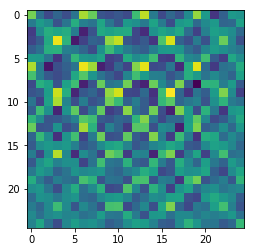

In [291]:
plt.imshow((Φ_mat@x_sol).reshape((n_f,n_f)))